In [14]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from copy import deepcopy
from tqdm import tqdm

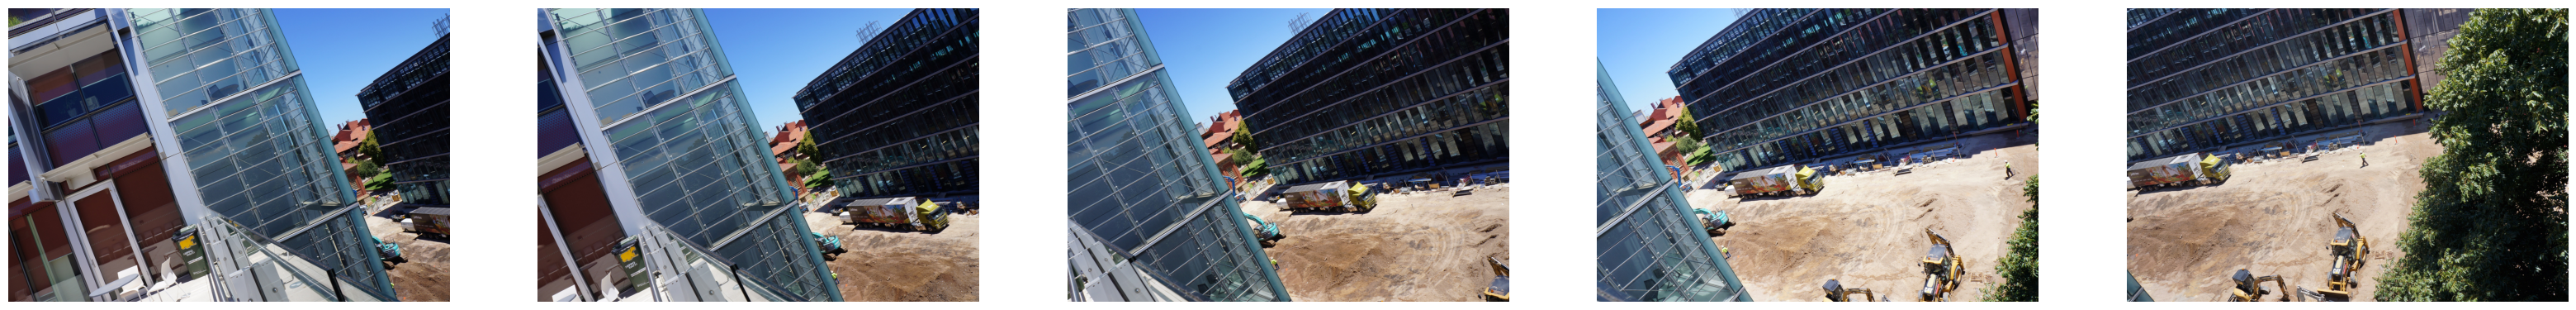

In [15]:
image_files = glob.glob('../../Images/I5/*')
images = [plt.imread(img) for img in image_files]

fig, axes = plt.subplots(1, len(images), figsize=(40, 5))
for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [16]:
# Initialize the SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors using SIFT for all images
keypoints = []
descriptors = []
for img in images:
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)

# Create a BFMatcher object with default parameters
bf = cv2.BFMatcher()

# Find the best match between consecutive pairs of images
all_good_matches = []

for i in range(len(images) - 1):
    # Match descriptors using KNN
    matches = bf.knnMatch(descriptors[i], descriptors[i + 1], k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Store the good matches for the current pair
    all_good_matches.append(good_matches)


In [17]:
def compute_homography(src_pts, dst_pts):
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i][0]
        xp, yp = dst_pts[i][0]
        A.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)
    U, S, Vh = np.linalg.svd(A)
    L = Vh[-1, :] / Vh[-1, -1]
    H = L.reshape(3, 3)
    return H

def ransac_homography(src_pts, dst_pts, num_iterations=1000, threshold=5.0):
    max_inliers = 0
    best_H = None
    inliers_list = []

    for _ in tqdm(range(num_iterations)):
        # Randomly select 4 points
        indices = np.random.choice(len(src_pts), 4, replace=False)
        src_sample = src_pts[indices]
        dst_sample = dst_pts[indices]

        # Compute homography matrix
        H = compute_homography(src_sample, dst_sample)

        # Transform all source points
        src_pts_homogeneous = np.concatenate([src_pts, np.ones((len(src_pts), 1, 1))], axis=2)
        projected_pts = np.dot(H, src_pts_homogeneous.reshape(-1, 3).T).T
        projected_pts = projected_pts[:, :2] / projected_pts[:, 2:]

        # Compute the number of inliers
        distances = np.linalg.norm(projected_pts - dst_pts.reshape(-1, 2), axis=1)
        inliers = distances < threshold
        num_inliers = np.sum(inliers)

        # Update the best homography matrix if the current one has more inliers
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            inliers_list = deepcopy(inliers)
        
    src_sample = src_pts[inliers_list]
    dst_sample = dst_pts[inliers_list]
    H = compute_homography(src_sample, dst_sample)


    return H, len(inliers_list)

In [18]:
homographies = []

for i in range(len(all_good_matches)):
    # Extract the matched keypoints
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in all_good_matches[i]]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints[i + 1][m.trainIdx].pt for m in all_good_matches[i]]).reshape(-1, 1, 2)
    
    # Compute the homography matrix
    H, mask = ransac_homography(src_pts, dst_pts)
    
    # Store the homography matrix
    homographies.append(H)

print("Homography matrices:")
for i, H in enumerate(homographies):
    print(f"Pair {i} -> {i+1}:\n{H}\n")

100%|██████████| 1000/1000 [00:00<00:00, 1740.20it/s]


Homography matrices:
Pair 0 -> 1:
[[ 1.27139350e+00  6.01307235e-02 -6.38334643e+02]
 [ 2.57975578e-02  1.14651881e+00 -2.90152291e+00]
 [ 1.28451445e-04  1.59325677e-06  1.00000000e+00]]

Pair 1 -> 2:
[[ 1.29993805e+00  4.89317181e-02 -6.82542534e+02]
 [ 4.71397938e-02  1.18279343e+00 -1.14159241e+02]
 [ 1.40745200e-04  1.37900303e-05  1.00000000e+00]]

Pair 2 -> 3:
[[ 1.24740410e+00  5.22877761e-02 -5.73334638e+02]
 [ 3.57884361e-02  1.15962648e+00 -1.24993487e+02]
 [ 1.17457698e-04  2.03982199e-05  1.00000000e+00]]

Pair 3 -> 4:
[[ 1.34048790e+00  3.15860831e-02 -8.42086336e+02]
 [ 9.50303089e-02  1.23273221e+00 -1.94650348e+02]
 [ 1.71575084e-04  1.49642546e-05  1.00000000e+00]]



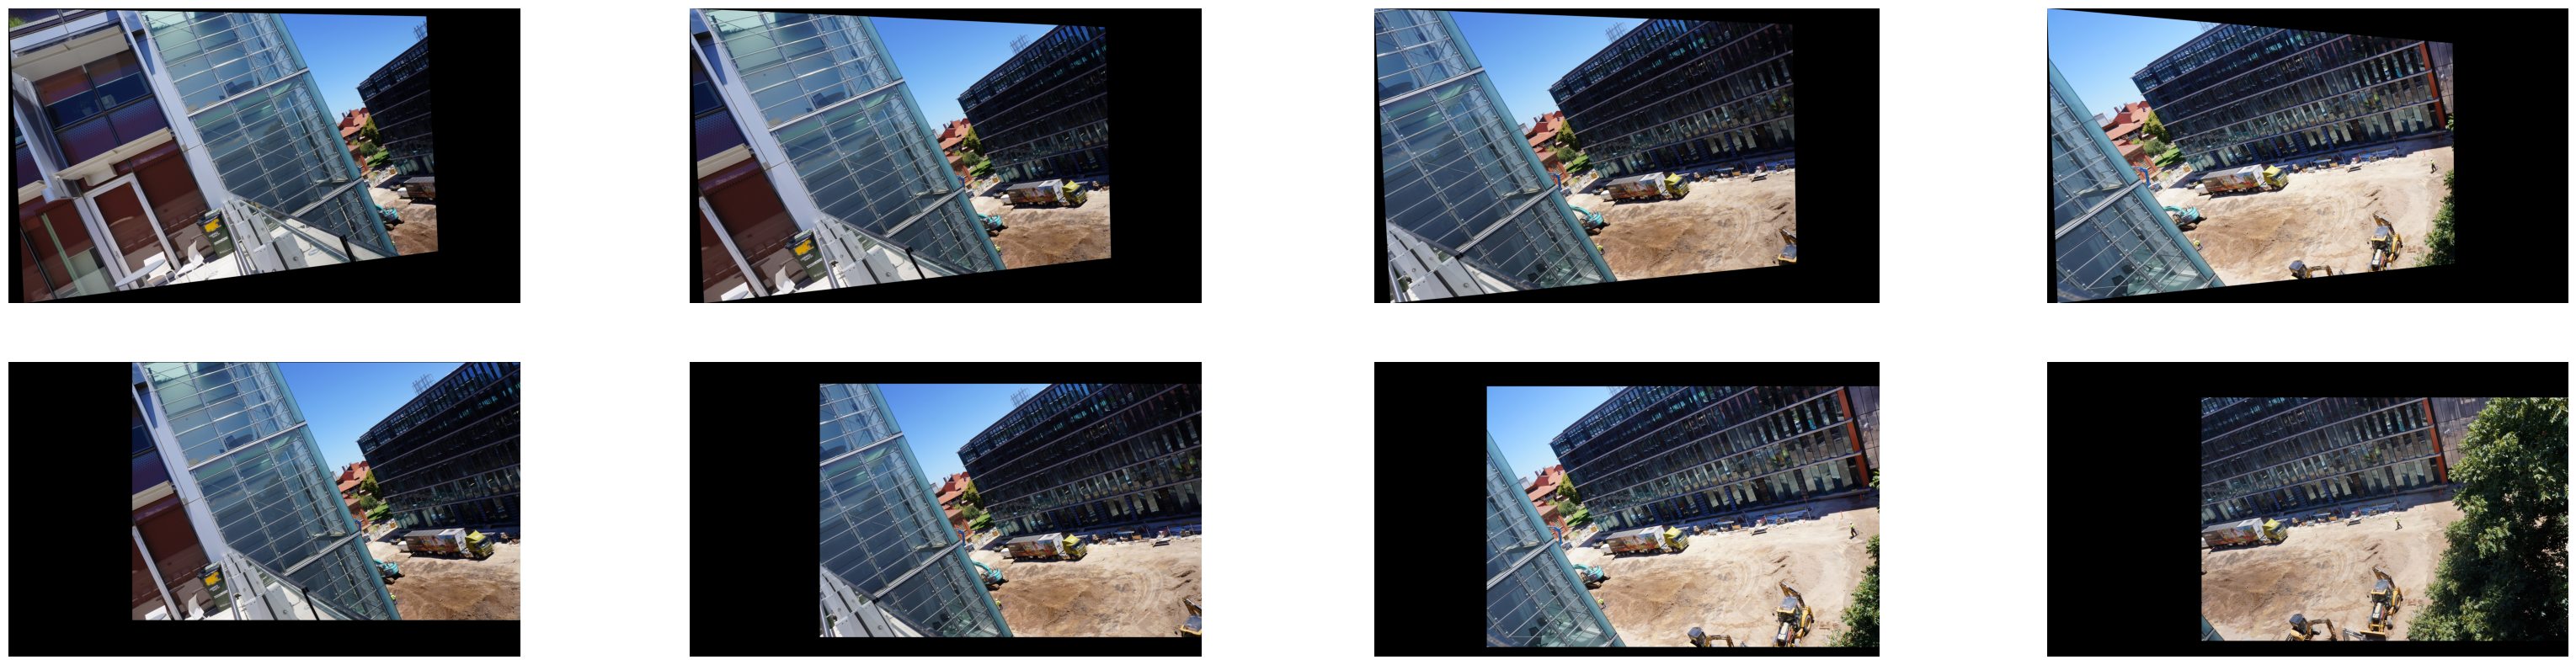

In [19]:
# Warp the images using the homography matrices for each pair
warped_images = []
canvas_sizes = []
adjusted_H_matrices = []
translation_matrices = []

for i in range(len(homographies)):
    H = homographies[i]
    img1 = images[i]
    img2 = images[i + 1]
    
    # Compute the bounding box for img1
    h1, w1 = img1.shape[:2]
    corners1 = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32).reshape(-1, 1, 2)
    transformed_corners1 = cv2.perspectiveTransform(corners1, H)
    
    # Compute the bounding box for img2
    h2, w2 = img2.shape[:2]
    corners2 = np.array([[0, 0], [w2, 0], [w2, h2], [0, h2]], dtype=np.float32).reshape(-1, 1, 2)
    
    # Combine the corners
    all_corners = np.vstack((transformed_corners1, corners2))
    
    # Find the bounding box of the combined corners
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())
    
    # Compute the size of the bounding box
    width = xmax - xmin
    height = ymax - ymin
    
    # Adjust the homography matrix to account for the translation
    translation_matrix = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]]).astype(np.float32)
    adjusted_H = translation_matrix @ H
    
    # Warp img1 using the adjusted homography matrix
    warped_img1 = cv2.warpPerspective(img1, adjusted_H, (width, height))
    
    # Translate img2
    translated_img2 = cv2.warpPerspective(img2, translation_matrix, (width, height))
    
    warped_images.append((warped_img1, translated_img2))
    canvas_sizes.append((height, width))
    adjusted_H_matrices.append(adjusted_H)
    translation_matrices.append(translation_matrix)

# Display the warped images
fig, axes = plt.subplots(2, len(warped_images), figsize=(40, 10))
for i, (img1, img2) in enumerate(warped_images):
    axes[0, i].imshow(img1)
    axes[0, i].axis('off')
    axes[1, i].imshow(img2)
    axes[1, i].axis('off')
plt.show()

# Print the stored values
#print("Canvas sizes:", canvas_sizes)
#print("Adjusted Homography Matrices:", adjusted_H_matrices)
#print("Translation Matrices:", translation_matrices)

In [20]:
def single_weights_array(size: int) -> np.ndarray:
    """
    Create a 1D weights array.

    Args:
        size: Size of the array

    Returns:
        weights: 1D weights array
    """
    if size % 2 == 1:
        return np.concatenate(
            [np.linspace(0, 1, (size + 1) // 2), np.linspace(1, 0, (size + 1) // 2)[1:]]
        )
    else:
        return np.concatenate([np.linspace(0, 1, size // 2), np.linspace(1, 0, size // 2)])


def single_weights_matrix(shape: tuple[int]) -> np.ndarray:
    """
    Create a 2D weights matrix.

    Args:
        shape: Shape of the matrix

    Returns:
        weights: 2D weights matrix
    """
    return (
        single_weights_array(shape[0])[:, np.newaxis]
        @ single_weights_array(shape[1])[:, np.newaxis].T
    )

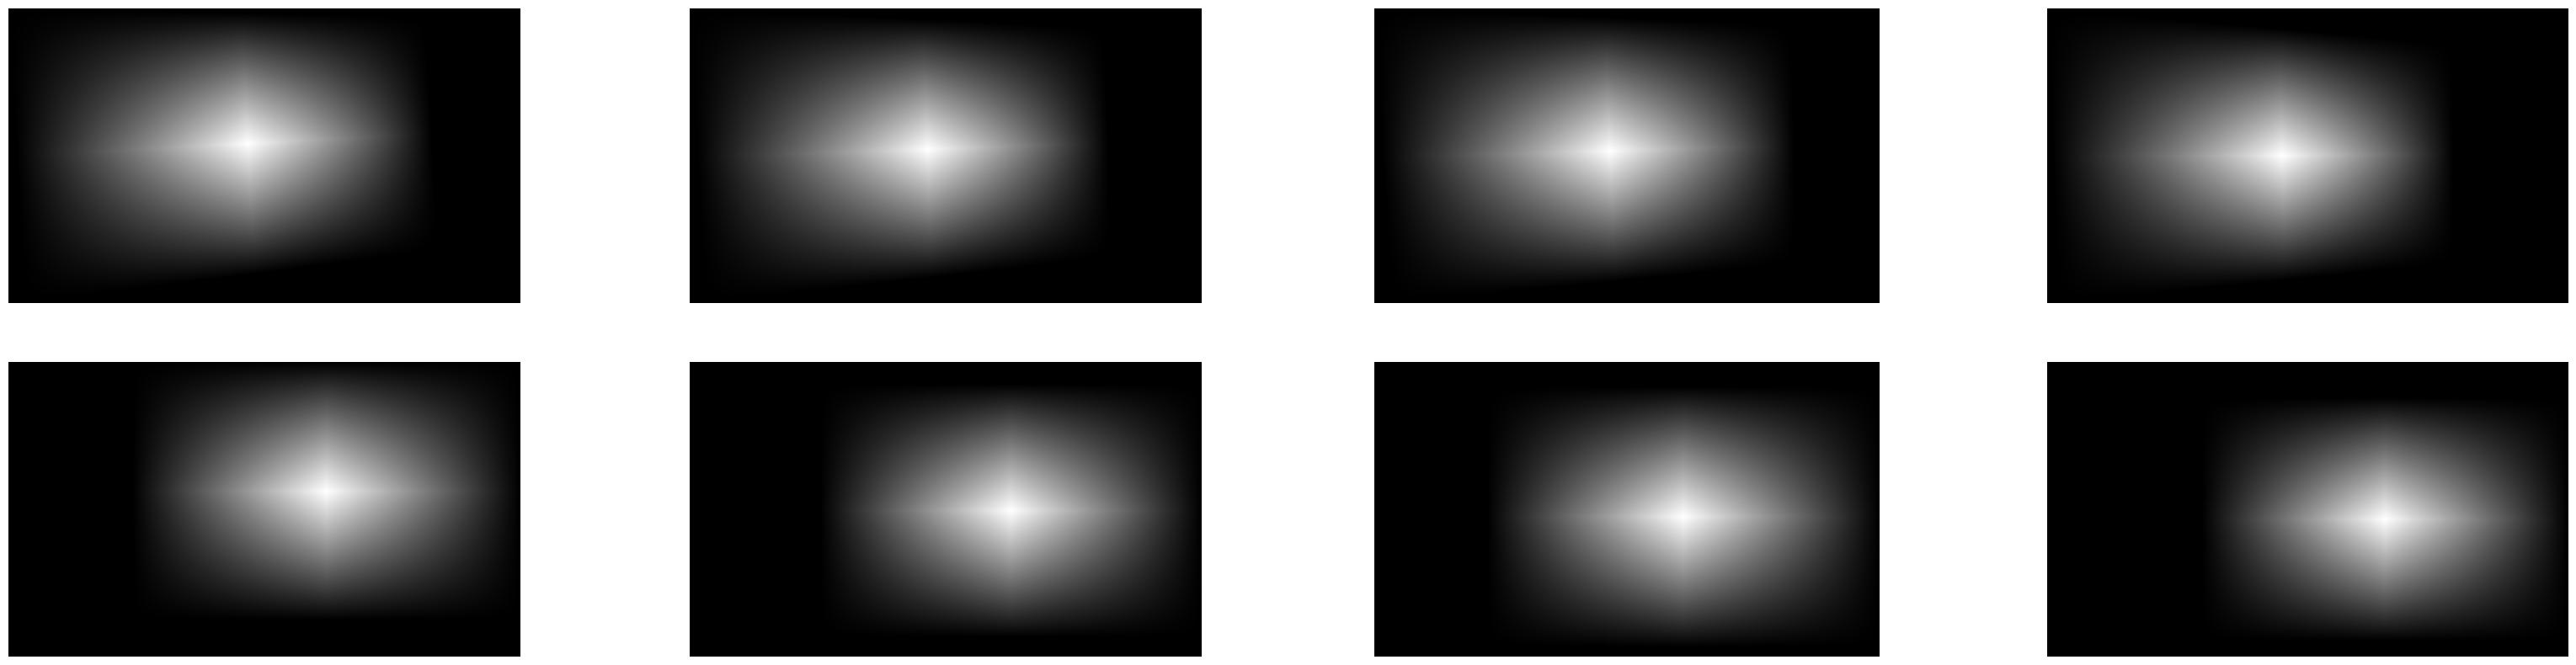

In [21]:
masks1 = []
masks2 = []

for i in range(len(homographies)):
    H = homographies[i]
    img1 = images[i]
    img2 = images[i + 1]
    
    # Create a mask for img1 and img2
    mask1 = single_weights_matrix(img1.shape[:2])
    mask2 = single_weights_matrix(img2.shape[:2])
    
    # Use the stored adjusted homography and translation matrices
    adjusted_H = adjusted_H_matrices[i]
    translation_matrix = translation_matrices[i]
    width, height = canvas_sizes[i][1], canvas_sizes[i][0]
    
    # Warp the masks using the homography matrices
    warped_mask1 = cv2.warpPerspective(mask1, adjusted_H, (width, height))
    warped_mask2 = cv2.warpPerspective(mask2, translation_matrix, (width, height))
    
    masks1.append(warped_mask1)
    masks2.append(warped_mask2)

# Display the masks
fig, axes = plt.subplots(2, len(masks1), figsize=(40, 10))
for i, (mask1, mask2) in enumerate(zip(masks1, masks2)):
    axes[0, i].imshow(mask1, cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(mask2, cmap='gray')
    axes[1, i].axis('off')
plt.show()

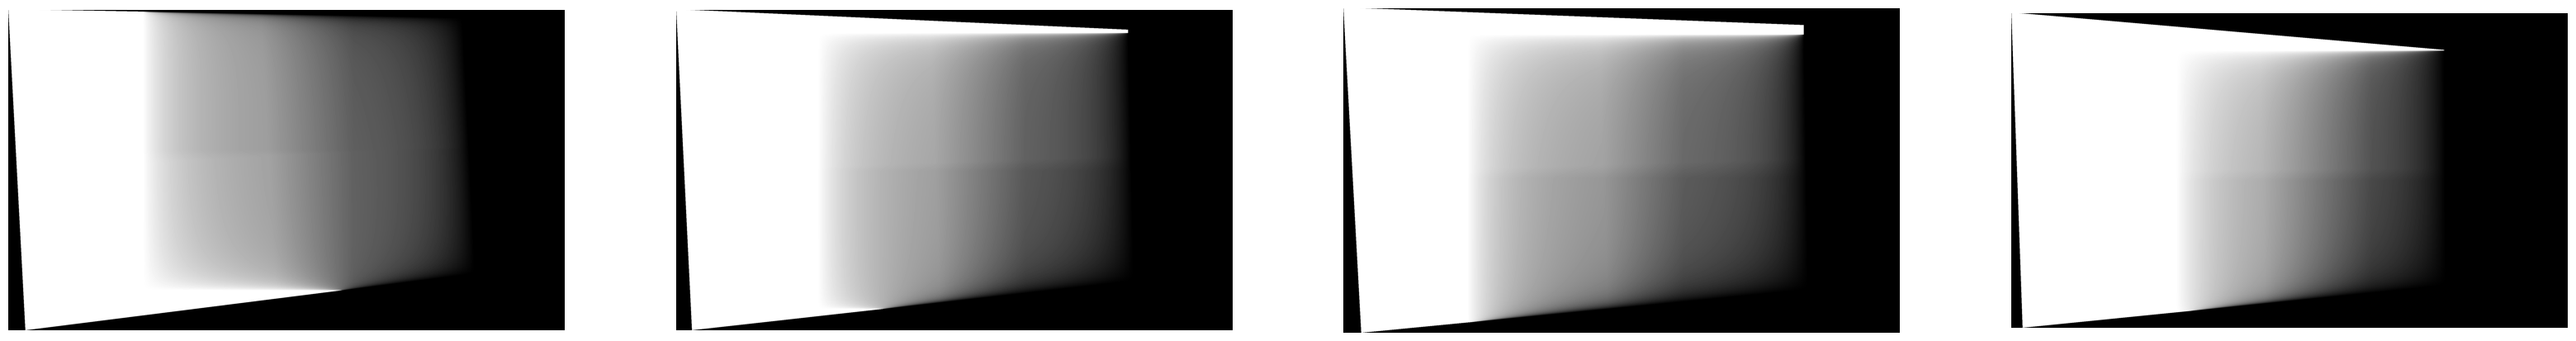

In [22]:
normalised_masks1 = [np.divide(mask1, mask1+mask2, out=np.zeros_like(mask1), where=mask1+mask2>0) for mask1, mask2 in zip(masks1, masks2)]
# Display the normalized masks
fig, axes = plt.subplots(1, len(normalised_masks1), figsize=(40, 10))
for ax, norm_mask in zip(axes, normalised_masks1):
    ax.imshow(norm_mask, cmap='gray')
    ax.axis('off')
plt.show()

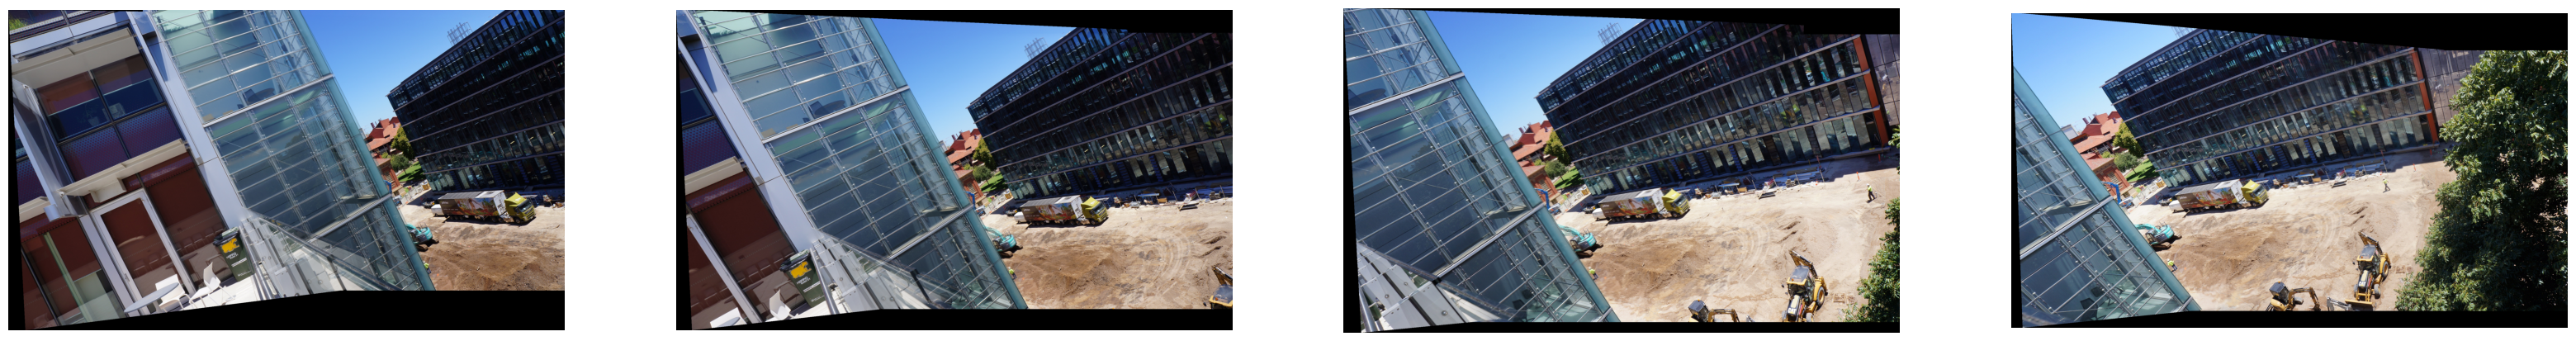

In [23]:
# Apply the normalized masks to the combined images
final_images = []

for pairs_of_imgs, norm_mask in zip(warped_images, normalised_masks1):
    # Apply the mask to the combined image
    final_img = pairs_of_imgs[0] * norm_mask[:, :, np.newaxis] + pairs_of_imgs[1] * (1 - norm_mask[:, :, np.newaxis])
    final_images.append(final_img.astype(np.uint8))

# Display the final images
fig, axes = plt.subplots(1, len(final_images), figsize=(40, 10))
for ax, img in zip(axes, final_images):
    ax.imshow(img)
    ax.axis('off')
plt.show()